# ***Search Memes using TF-IDF & Word2Vec***

In [149]:
#!pip install pandas spacy nltk wordcloud

## **Modules**

In [172]:
import pandas as pd
import spacy
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import cv2
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from gensim.models import Word2Vec
import pickle
import gensim

if False:
    !rm -r /kaggle/working/*
    nltk.data.path.append('/kaggle/working/nltk_data')
    
    nltk.download('punkt', download_dir='/kaggle/working/nltk_data')
    nltk.download('stopwords', download_dir='/kaggle/working/nltk_data')
    nltk.download('wordnet', download_dir='/kaggle/working/nltk_data')
    nltk.download('omw-1.4', download_dir='/kaggle/working/nltk_data')
    !unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora

## **Loading Data & Basic Preprocessing**

In [147]:
#loading json
df = pd.read_json('/kaggle/input/meme-convx/memes-trainval.json')
df.drop(columns = ['url', 'title', 'category', 'post_id', 'metaphors'], inplace = True)

#merging captions to enhance search
df1 = df[['img_captions', 'img_fname']]
df2 = df[['meme_captions', 'img_fname']]

df1 = df1.copy()
df2 = df2.copy()

df1.rename(columns={'img_captions': 'captions'}, inplace=True)
df2.rename(columns={'meme_captions': 'captions'}, inplace=True)

df = pd.concat([df2, df1], ignore_index=True)

#list to string
def make_it_string(st):
    return st[0]

df['captions'] = df['captions'].apply(make_it_string)

In [148]:
df.head()

,captions,img_fname
0,Meme poster is frustrated about the format of ...,memes_bpet7l.png
1,Meme poster is saying that searching Google pl...,memes_ctxvmu.png
2,Meme poster is feeling sad.,memes_cxvuqd.png
3,Meme poster is saying that Reddit is more fun ...,memes_cyop7a.png
4,Meme poster is making fun of the Area 51 raid.,memes_cz2i20.png


## **Formal Preprocessing**

In [149]:
#class to preprocess the text
class MemePreprocessor:
    def __init__(self, df):
        self.df = df
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english"))
        self.stop_words = self.stop_words.union({'meme', 'poster', 'try', 'convey'})

    #line by line processing
    def _preprocess_text(self, text):
        text = text.lower() #lower
        text = re.sub(r'[^a-z\s]', '', text) #special charaters        
        
        tokens = word_tokenize(text) #tokenize 

        processed_tokens = []
        for word in tokens:
            if word.isalpha() and word not in self.stop_words: #stop words
                lemmatized_word = self.lemmatizer.lemmatize(word, pos='v') #lemmatization
                processed_tokens.append(lemmatized_word)

        return " ".join(processed_tokens)
        
    #overall dataframe processing
    def _preprocess_dataframe(self):
        self.df['captions'] = self.df['captions'].apply(self._preprocess_text)
        return self.df

In [150]:
#preprocessing the text
m_processor = MemePreprocessor(df)
df = m_processor._preprocess_dataframe()

In [151]:
df.head()

,captions,img_fname
0,frustrate format website make suggestion impro...,memes_bpet7l.png
1,say search google plus term want search reddit...,memes_ctxvmu.png
2,feel sad,memes_cxvuqd.png
3,say reddit fun instagram,memes_cyop7a.png
4,make fun area raid,memes_cz2i20.png


## **Vizualizations**

<ipython-input-96-59e849ef3c5c>:20: UserWarning:

FixedFormatter should only be used together with FixedLocator



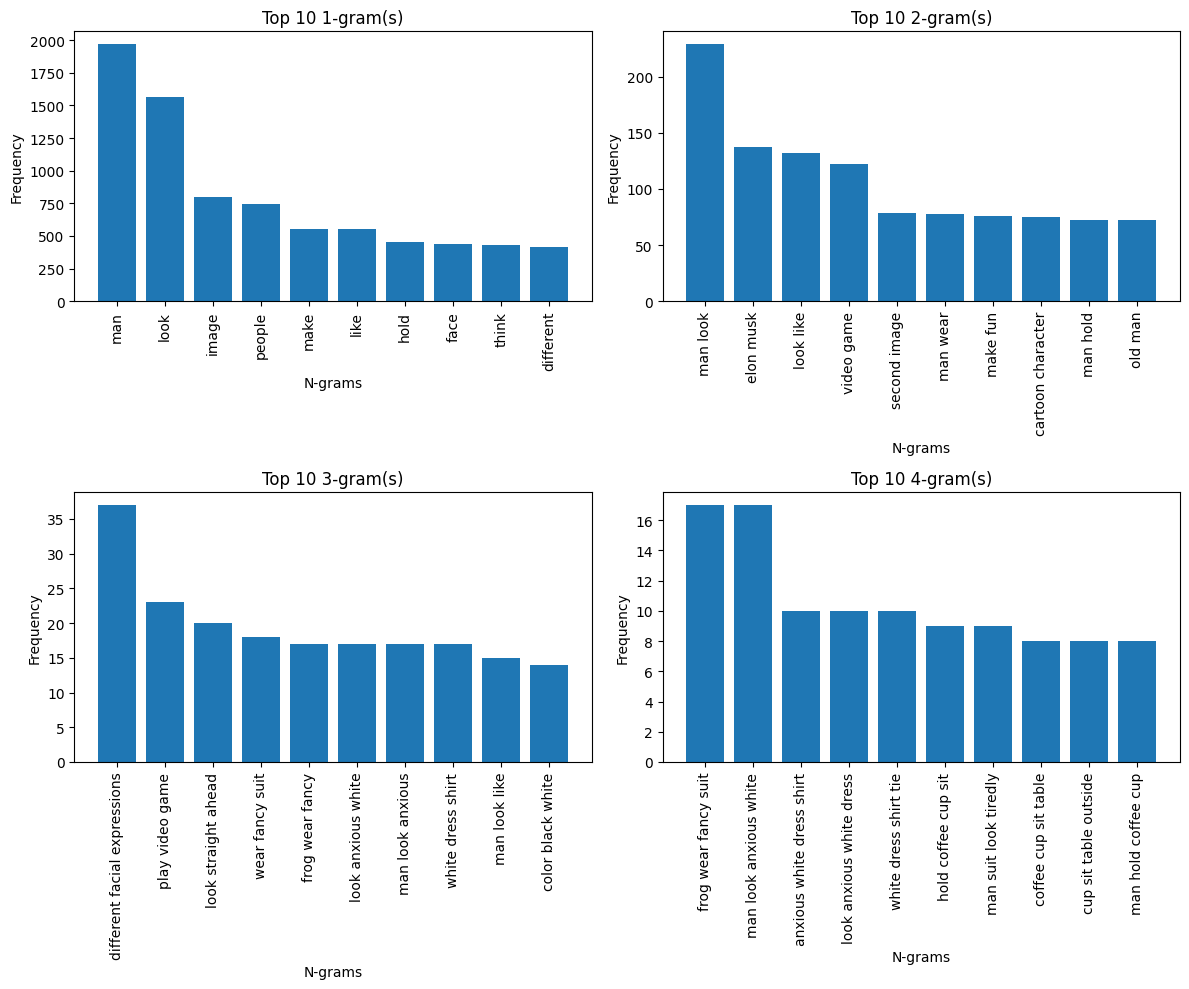

In [96]:
# this part vizualization is written with the help of GPT
def plot_frequent_ngrams(df, ngram_range=(1, 1), top_n=10, ax=None):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngram_matrix = vectorizer.fit_transform(df['captions'])
    
    ngram_freq = ngram_matrix.sum(axis=0).A1
    ngrams = vectorizer.get_feature_names_out()
    
    sorted_ngrams = sorted(zip(ngrams, ngram_freq), key=lambda x: x[1], reverse=True)[:top_n]
    
    if sorted_ngrams:
        ngram_labels, ngram_values = zip(*sorted_ngrams)
    else:
        ngram_labels, ngram_values = [], []
    
    ax.bar(ngram_labels, ngram_values)
    ax.set_xlabel('N-grams')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Top {top_n} {ngram_range[0]}-gram(s)')
    ax.set_xticklabels(ngram_labels, rotation=90)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_frequent_ngrams(df, ngram_range=(1, 1), top_n=10, ax=axes[0, 0])
plot_frequent_ngrams(df, ngram_range=(2, 2), top_n=10, ax=axes[0, 1])
plot_frequent_ngrams(df, ngram_range=(3, 3), top_n=10, ax=axes[1, 0])
plot_frequent_ngrams(df, ngram_range=(4, 4), top_n=10, ax=axes[1, 1])

plt.tight_layout()
plt.show()

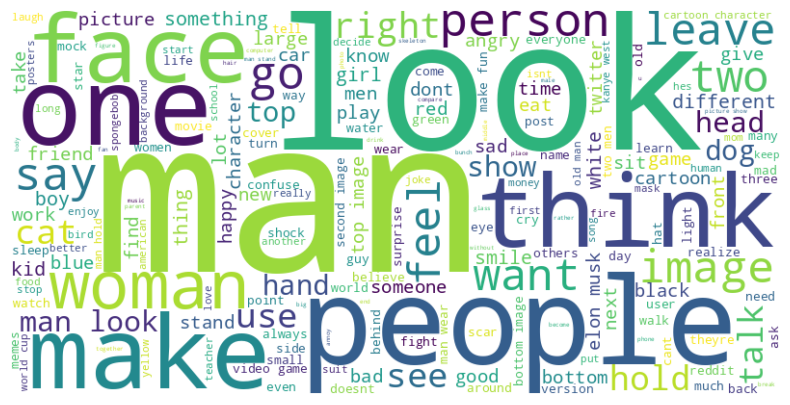

In [97]:
text_for_wordcloud = " ".join(df['captions'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Cosine Similarity Function**
```
def cosine_similarity(A, B):
    return np.dot(A,B)/(norm(A)*norm(B))
```

## **Searching through TF-IDF**

In [105]:
#making vector object
tfidf_vectorizer = TfidfVectorizer()

#fitting matrix
matrix = tfidf_vectorizer.fit_transform(df['captions']).toarray()
tfidf_df = pd.DataFrame(matrix)

#attachinbg np.array.matrix to the dataframe with corresponding names
tfidf_df = pd.concat([df['img_fname'], tfidf_df], axis=1)
tqdm.pandas()

tfidf_df[['img_fname', 'embedding']] = tfidf_df.progress_apply(
    lambda row: pd.Series([row['img_fname'], np.array(row[1:])]), axis=1
)

#storing embeddings and image names
tfidf_df = tfidf_df[['img_fname', 'embedding']]
tfidf_df.head()

100%|██████████| 11646/11646 [01:06<00:00, 174.00it/s]


,img_fname,embedding
0,memes_bpet7l.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,memes_ctxvmu.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,memes_cxvuqd.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,memes_cyop7a.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,memes_cz2i20.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [107]:
def recommend_tfidf(query: list, tfidf_vectorizer, tfidf_df):
    #text to vector embedding using transform module
    query_vector = tfidf_vectorizer.transform(query)
    
    #loading embeddings into RAM
    meme_vectors = np.array([np.array(embed) for embed in tfidf_df['embedding']])
    
    #comparing embeddings with query
    cosine_sim = np.array([cosine_similarity(query_vector, meme_vectors[i:i+1])[0][0] for i in tqdm(range(len(meme_vectors)), desc="Computing Cosine Similarity")])

    top_6_indices = cosine_sim.argsort()[-6:][::-1]
    top_6_images = tfidf_df.iloc[top_6_indices]['img_fname'].values
    top_6_scores = cosine_sim[top_6_indices]
    
    fig, axes = plt.subplots(2, 3, figsize=(10, 15))
    axes = axes.flatten()

    #using cv2 to plot because matplotlib doesn't work
    for i, (img_fname, score) in enumerate(zip(top_6_images, top_6_scores)):
        img_path = f'/kaggle/input/meme-convx/memes/memes/memes/{img_fname}'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))
        axes[i].imshow(img)
        axes[i].set_title(f'Similarity: {score:.2f}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

TF-IDF Recommendations:


Computing Cosine Similarity: 100%|██████████| 11646/11646 [00:16<00:00, 703.63it/s]


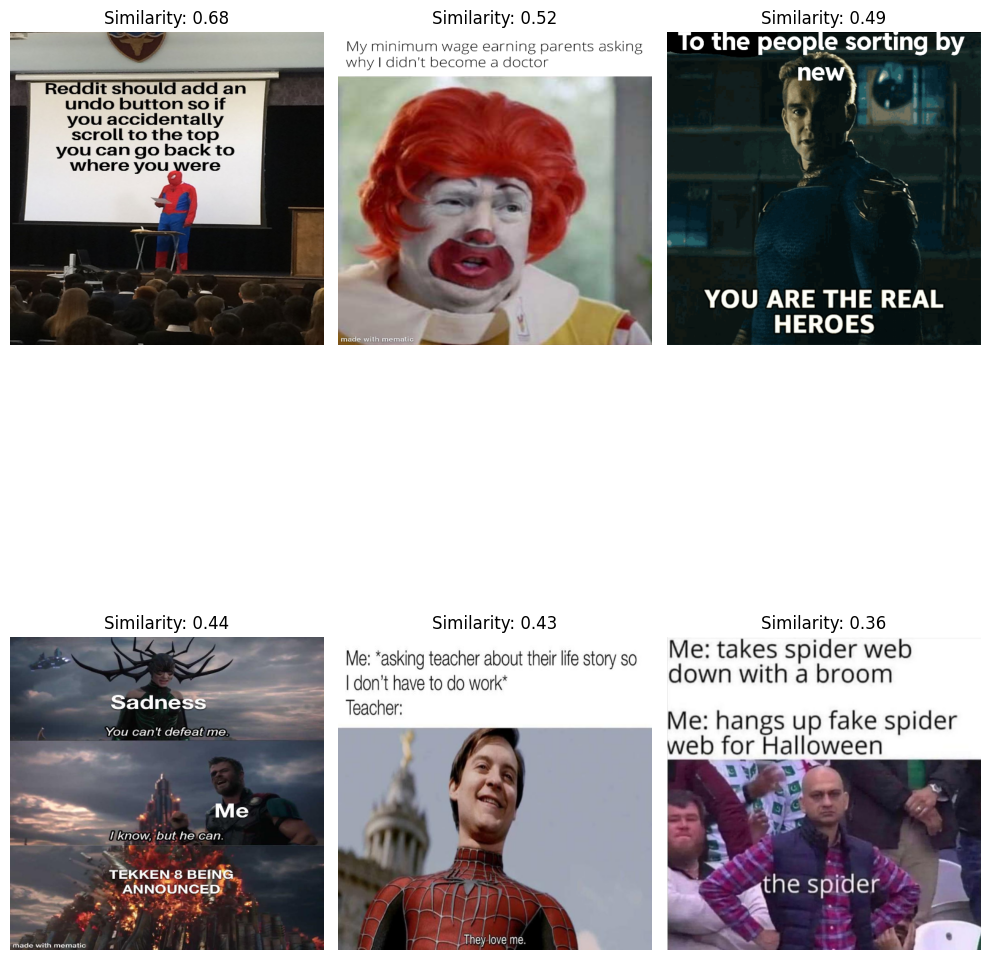

In [108]:
#searching the images corresponding to the query
query = ["Person in Spider Man outfit"]
print("TF-IDF Recommendations:")
recommend_tfidf(query, tfidf_vectorizer, tfidf_df)

## **Searching through Word2Vec**

In [152]:
w2v_df = df.copy()

In [161]:
#using tokenization module to tokenize
w2v_df['token_caps'] = w2v_df['captions'].apply(word_tokenize)

def fit(df, column_name = 'token_caps'): #fitting the data in model
    #SkipGram model with sg (skip gram) = 1
    skipgram_model = Word2Vec(sentences = df[column_name], vector_size = 512, window = 4, sg = 1, min_count=1, workers = 4, epochs = 100)
    #SkipGram model with sg (skip gram) = 0
    cbow_model = Word2Vec(sentences = df[column_name], vector_size = 512, window = 4, sg = 1, min_count=1, workers = 4, epochs = 100)

    return skipgram_model, cbow_model

def transform(token, model): #or we can call it average embedding from the text
    vectors = []
    for word in token:
        if word in model.wv:
            vectors.append(model.wv[word])
    if vectors:
        return np.mean(vectors, axis = 0)
    else:
        return np.zeros(model.vector_size)

#generating models
skipgram_model, cbow_model = fit(w2v_df)

#tranforming to get embeddings
w2v_df["cbow_vector"] = w2v_df["token_caps"].apply(lambda tokens: transform(tokens, cbow_model))
w2v_df["skipgram_vector"] = w2v_df["token_caps"].apply(lambda tokens: transform(tokens, skipgram_model))

In [162]:
def recommend_word2vec(query: list, model, w2v_df, vector_column):
    #text to vector embedding using transform module
    query = word_tokenize(query[0])
    query_vector = transform(query, model)

    #loading embeddings into RAM    
    meme_vectors = np.vstack(w2v_df[vector_column].values)

    #comparing embeddings with query
    cosine_sim = np.array([
        cosine_similarity(query_vector.reshape(1, -1), meme_vectors[i].reshape(1, -1))[0][0]
        for i in range(len(meme_vectors))
    ])

    top_6_indices = cosine_sim.argsort()[-6:][::-1]
    top_6_images = w2v_df.iloc[top_6_indices]['img_fname'].values
    top_6_scores = cosine_sim[top_6_indices]

    fig, axes = plt.subplots(2, 3, figsize=(10, 10))
    axes = axes.flatten()
    
    #using cv2 to plot because matplotlib doesn't work
    for i, (img_fname, score) in enumerate(zip(top_6_images, top_6_scores)):
        img_path = f'/kaggle/input/meme-convx/memes/memes/memes/{img_fname}'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))
        axes[i].imshow(img)
        axes[i].set_title(f'Similarity: {score:.2f}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Word2Vec Recommendations (Skip-Gram):


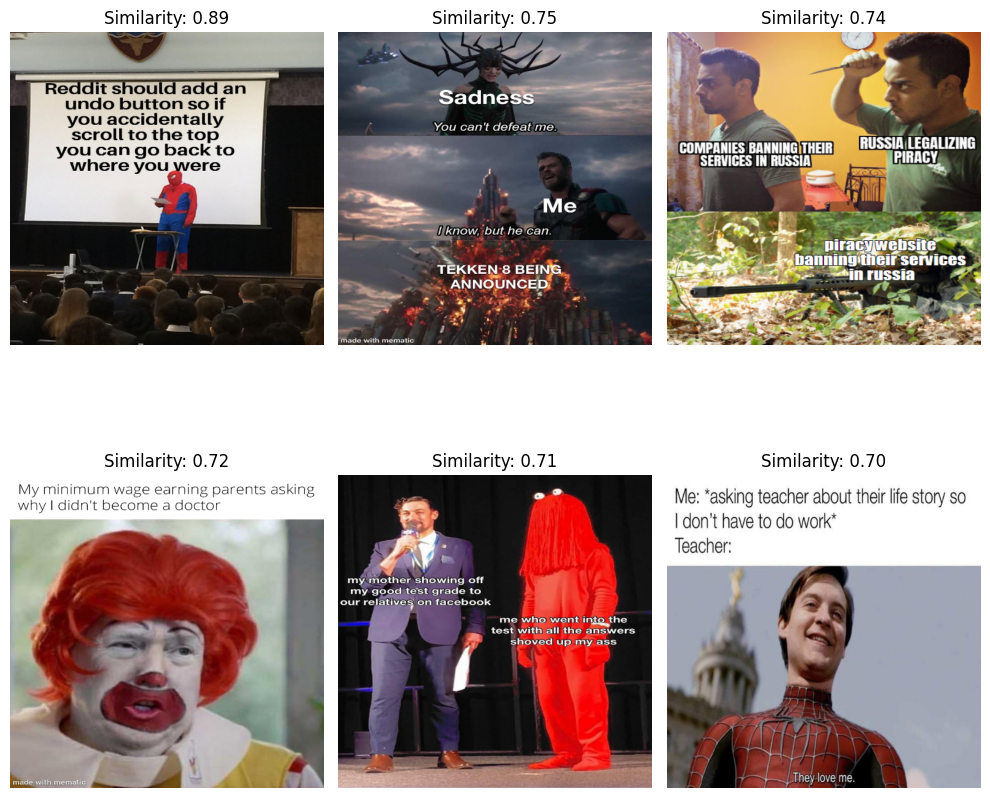

In [163]:
#searching the images corresponding to the query
query = ["person in spider man outfit"]
print("Word2Vec Recommendations (Skip-Gram):")
recommend_word2vec(query, skipgram_model, w2v_df, "skipgram_vector")

Word2Vec Recommendations (CBOW):


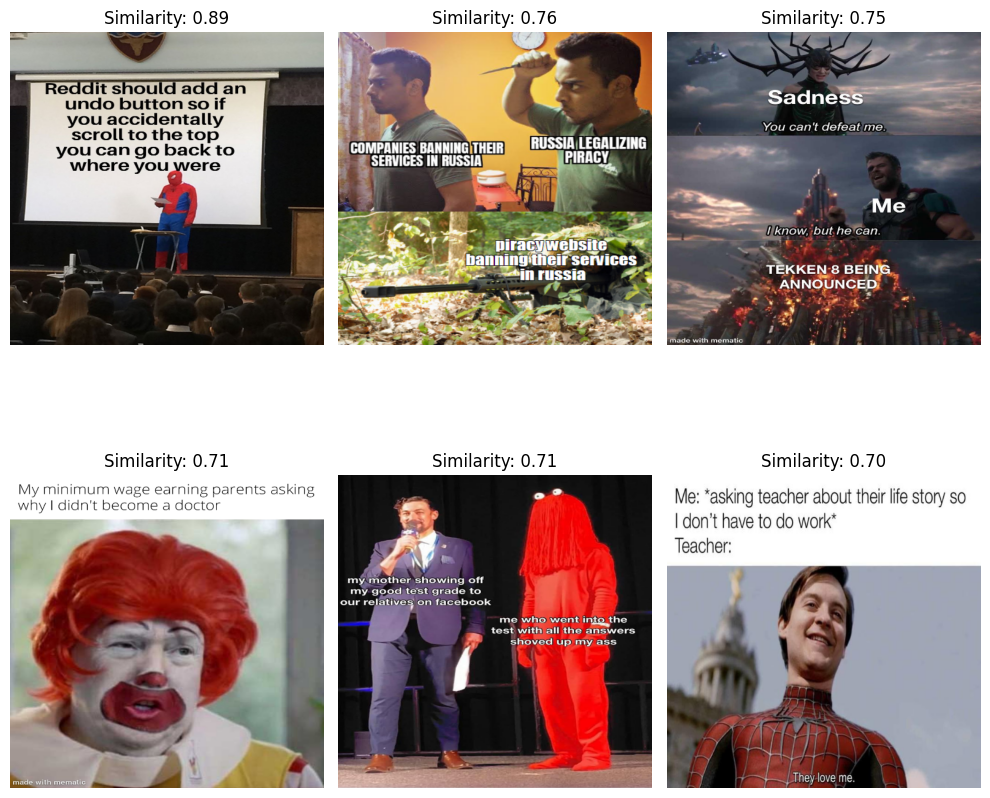

In [164]:
#searching the images corresponding to the query
query = ["person in spider man outfit"]
print("Word2Vec Recommendations (CBOW):")
recommend_word2vec(query, cbow_model, w2v_df, "cbow_vector")

## **Analysis/Limitations between TF-IDF & Word2Vec**

## **Inference Time:**
- TF-IDF is the slowest, taking approximately 16 seconds per inference.
- Word2Vec is significantly faster, with an inference time of only 3 seconds.
## **Training Time:**
- TF-IDF is the fastest, runs in O(n).
- Word2Vec is significantly slow, with an training time of 90 seconds (100 epochs).
## **Precision in Results:**
- TF-IDF tends to capture better textual features, making it effective for text-based image retrieval.
- Word2Vec, on the other hand, captures harder features that are not strictly textual, making it more versatile in identifying meaningful relationships between words.
## **Similarity Scores (for Similar Embeddings):**
- TF-IDF performs poorly, with similarity scores not aligning well with true embeddings. Specifically, when tested on 100% text-based images, it marked them with only a 67% similarity score.
- Word2Vec performs better, showing a more accurate representation of similarity. On the same 100% text-based images, it marked them with an 89% similarity score, indicating a stronger alignment with true embeddings.

### Final Verdict: **Word2Vec** is faster, focus on relationships and produces similar embeddings. 

## **Saving models**

In [ ]:
cbow_model.save("cbow_model.model")
skipgram_model.save("skipgram_model.model")

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

tfidf_df.to_pickle("tfidf_df.pkl")

## **Loading models**

In [ ]:
if False:
    cbow_model = gensim.models.Word2Vec.load("cbow_model.model")
    skipgram_model = gensim.models.Word2Vec.load("skipgram_model.model")
    
    with open("tfidf_vectorizer.pkl", "rb") as f:
        tfidf_vectorizer = pickle.load(f)
    
    tfidf_df = pd.read_pickle("tfidf_df.pkl")
    
    print("Models and data loaded successfully!")